# Modeling
## Clustering

in this notebook we are going to implement the clustering algorithms for stories and posts dataset. these two datasets hosts the stories and posts which published by the campaign's account. since the clusteirng is a unsupervised learning algorithm, and in these datasets we don't have dependent variable, this approach is our go to method for extracting insightful things out of these data. the goal of this step is to cluster posts and stories so the trained model will be able to predict the performance of aforementioned form of content.

we will implement two clustering algorithms, partitioned based clustering (K-means) and density based clustering (DBSCAN). before implementing these algorithms for each dataset we have to find the optimized number of neighbors which we will check via elbow and silhouette method

----

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import matplotlib
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
import seaborn as sns
from openpyxl import load_workbook
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from tqdm import tqdm_notebook, tqdm
from sklearn import preprocessing

In [2]:
xls = pd.ExcelFile('data/Main Dataset V3.0 .xlsx')
ad_post = pd.read_excel(xls, 'Ad-Post')
ad_story = pd.read_excel(xls, 'Ad-Story')
influencer = pd.read_excel(xls, 'Influencer')
leaders_post = pd.read_excel(xls, 'Leaders-Post')
leaders_story = pd.read_excel(xls, 'Leaders-Story')
post = pd.read_excel(xls, 'Post')
story = pd.read_excel(xls, 'Story')
print('Datasets Loaded Completely.')

Datasets Loaded Completely.


In [31]:
post['view'] = post['view'].fillna(0)

In [12]:
labels, _ = pd.factorize(story['type'])
story_labelencoded = story
story_labelencoded['type_labelencoded'] = labels.tolist()
story.drop(columns=['type'], axis=1, inplace=True)

In [33]:
post_x = np.asarray(post)
story_x = np.asarray(story)
post_x = preprocessing.StandardScaler().fit(post_x).transform(post_x)
story_x = preprocessing.StandardScaler().fit(story_x).transform(story_x)

### Elbow & Silhouette Method

In [14]:
from scipy.spatial.distance import cdist 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [34]:
def calc_elbow(X, no_clusters):
    '''
    This functions is for calculating the elbow method, this code is mainly inspired and refactored from:
    https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/    last update: 06 Jun, 2019
        Input -> X: array of Xs for calculating Kmeans
                 no_clusters: number of clusters we want to test.
        Returns -> Distortions 
                   Inertias (to get more information please check the refrence.)
    '''
    
    distortions = [] 
    inertias = [] 
    for k in tqdm(range(1, no_clusters + 1)): 
        #Building and fitting the model 
        clus_kmean = KMeans(n_clusters=k).fit(X) 
        clus_kmean.fit(X)     
        distortions.append(sum(np.min(cdist(X, clus_kmean.cluster_centers_, 
                          'euclidean'),axis=1)) / X.shape[0]) 
        inertias.append(clus_kmean.inertia_)
    return distortions, inertias


def calc_silhouette(X, no_clusters):
    '''
    This function is for calculating the sillhouette method, this code is mainly inspired and refactored from:
    https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb      by: Khyati Mahendru - Jun 17, 2019
        Input -> X: array of Xs for calculating Kmeans
                 no_clusters: number of clusters we want to test.
        Returns -> sil: array of silhouette scores for each number of clusters.
    '''
    sil = []
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in tqdm(range(2, no_clusters + 1)):
        clus_kmean = KMeans(n_clusters = k).fit(X)
        labels = clus_kmean.labels_
        sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    return sil

In [40]:
dist_post, inert_post = calc_elbow(post_x, post_x.shape[0])
dist_story, inert_story = calc_elbow(story_x, story_x.shape[0])

100%|██████████| 40/40 [00:06<00:00,  6.28it/s]


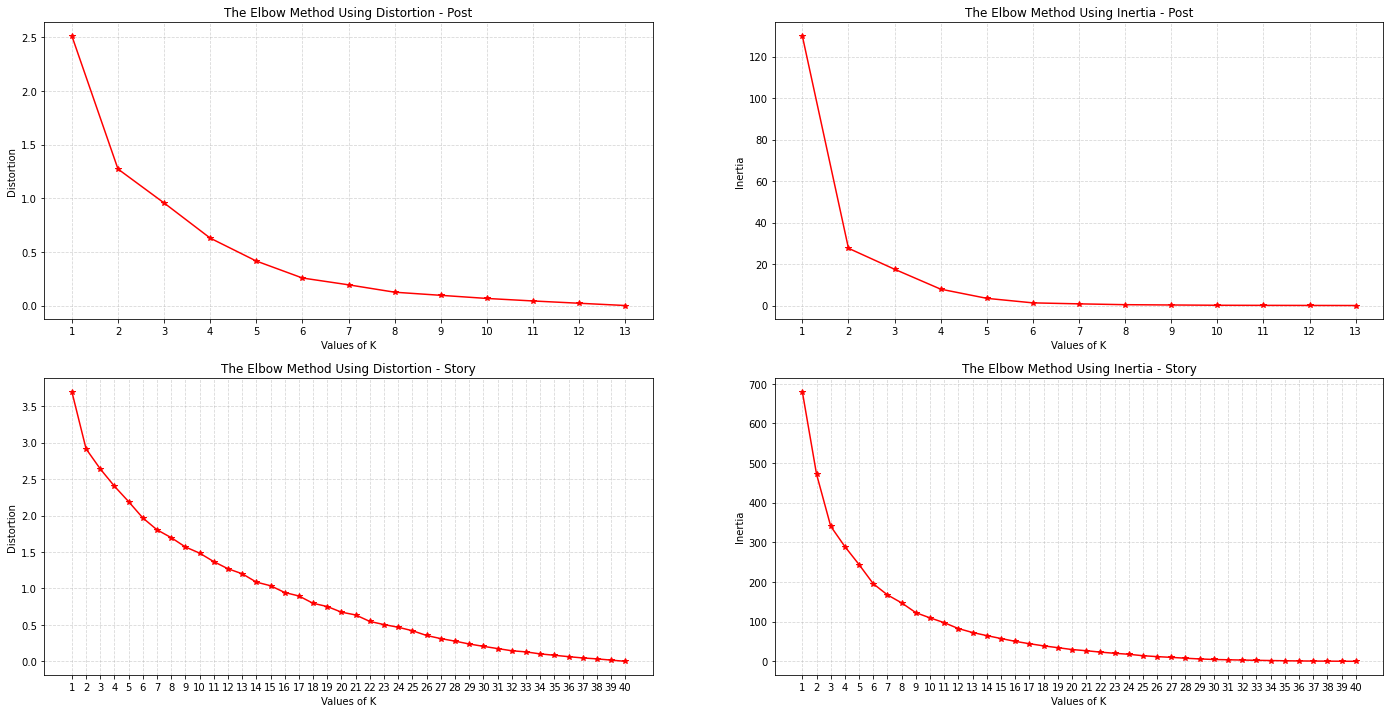

In [45]:
fig = plt.figure(figsize = (24, 12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(range(1, post_x.shape[0] + 1), dist_post, 'r*-')
ax1.set_ylabel('Distortion')
ax1.set_xlabel('Values of K')
ax1.set_title('The Elbow Method Using Distortion - Post')
ax1.grid(linestyle='--', alpha=0.5)
ax1.set_xticks(range(1, post_x.shape[0] + 1))
ax2.plot(range(1, post_x.shape[0] + 1), inert_post, 'r*-')
ax2.set_ylabel('Inertia')
ax2.set_xlabel('Values of K')
ax2.set_title('The Elbow Method Using Inertia - Post')
ax2.grid(linestyle='--', alpha=0.5)
ax2.set_xticks(range(1, post_x.shape[0] + 1))

ax3.plot(range(1, story_x.shape[0] + 1), dist_story, 'r*-')
ax3.set_ylabel('Distortion')
ax3.set_xlabel('Values of K')
ax3.set_title('The Elbow Method Using Distortion - Story')
ax3.grid(linestyle='--', alpha=0.5)
ax3.set_xticks(range(1, story_x.shape[0] + 1))
ax4.plot(range(1, story_x.shape[0] + 1), inert_story, 'r*-')
ax4.set_ylabel('Inertia')
ax4.set_xlabel('Values of K')
ax4.set_title('The Elbow Method Using Inertia - Story')
ax4.grid(linestyle='--', alpha=0.5)
ax4.set_xticks(range(1, story_x.shape[0] + 1))
    
plt.show()

as you can see in the graph above, we have a solid elbow point in posts datasets which is **2**, but there are no solid and definite point of elbow in story dataset, the most appropriate elbow point in story dataset seems to be **3**.

In [47]:
sil_post = calc_silhouette(post_x, post_x.shape[0] - 1)
sil_story = calc_silhouette(story_x, story_x.shape[0] - 1)

100%|██████████| 38/38 [00:02<00:00, 15.38it/s]


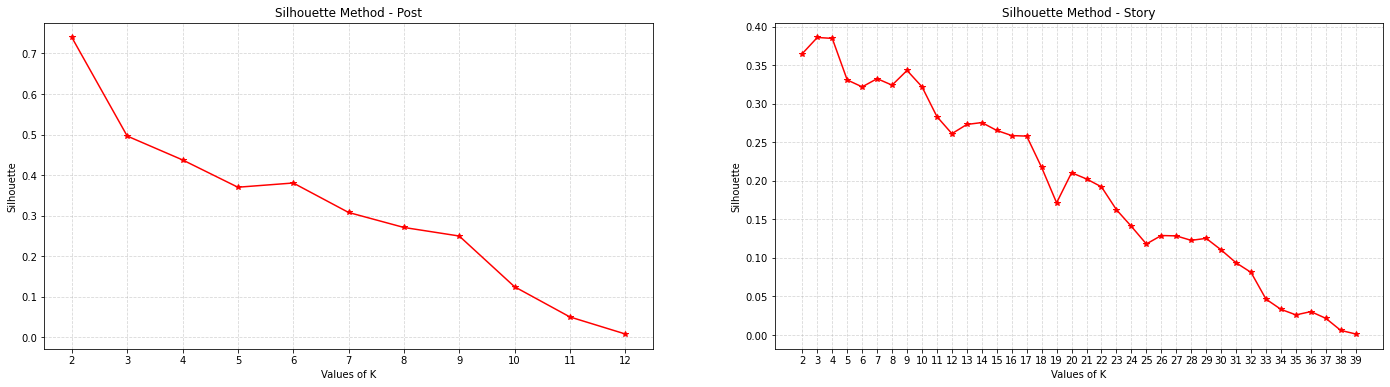

In [48]:
fig = plt.figure(figsize = (24, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(range(2, post_x.shape[0]), sil_post, 'r*-')
ax1.set_ylabel('Silhouette')
ax1.set_xlabel('Values of K')
ax1.set_title('Silhouette Method - Post')
ax1.grid(linestyle='--', alpha=0.5)
ax1.set_xticks(range(2, post_x.shape[0]))

ax2.plot(range(2, story_x.shape[0]), sil_story, 'r*-')
ax2.set_ylabel('Silhouette')
ax2.set_xlabel('Values of K')
ax2.set_title('Silhouette Method - Story')
ax2.grid(linestyle='--', alpha=0.5)
ax2.set_xticks(range(2, story_x.shape[0]))
    
plt.show()

As I anticipated, Silhouette method gives us a better definition, Although the estimated values for K with elbow method was correct, **2 clusters** for post dataset and **3 clusters** for story dataset give us the best performance. It's worth to mention that in post dataset highest score we can achieve via silhouette estimation is a little of than 0.70 and in story dataset is ~0.35.

This fact means that Partitioned based clustering is not good solution for our clustering problem. Regardless of this matter, I'm going to implement it since it just a few lines and after that we can move to the next method.

### K-Means

In [49]:
clus_kmeans_post = KMeans(n_clusters = 2).fit(post_x)
clus_kmeans_story = KMeans(n_clusters = 3).fit(story_x)
labels_post = clus_kmeans_post.labels_
labels_story = clus_kmeans_story.labels_

df_post_kmeans = post
df_story_kmeans = story
df_post_kmeans['clus_kmeans'] = labels_post
df_story_kmeans['clus_kmeans'] = labels_story

In [51]:
df_post_kmeans.groupby('clus_kmeans').mean()

,post_no,like,comment,share,save,profile_visit,reach,impression,ig_tv,view
clus_kmeans,,,,,,,,,,
0,7.91,464.36,62.45,25.64,18.82,56.27,2962.00,3572.91,0.09,251.09
1,2.00,1763.00,15537.00,1155.00,255.00,342.00,10958.50,13100.00,1.00,134375.00


In [52]:
df_story_kmeans.groupby('clus_kmeans').mean()

,story_no,view,action,reply,profile_visit,share,website_click,sticker_tap,impression,follow,navigation,back,forward,next,exit,vote,type_labelencoded
clus_kmeans,,,,,,,,,,,,,,,,,
0,13.20,1118.60,49.47,4.53,39.00,5.20,0.73,0.00,1173.73,0.80,1365.93,70.47,893.27,139.47,256.13,18.27,0.27
1,22.04,615.09,13.65,2.35,9.83,1.48,0.00,0.00,629.17,0.09,721.96,30.22,495.35,72.30,123.91,3.22,0.35
2,37.50,789.50,295.00,2.50,20.00,45.00,0.00,227.50,824.50,2.00,1125.00,293.00,550.50,-10.00,315.00,0.00,2.00


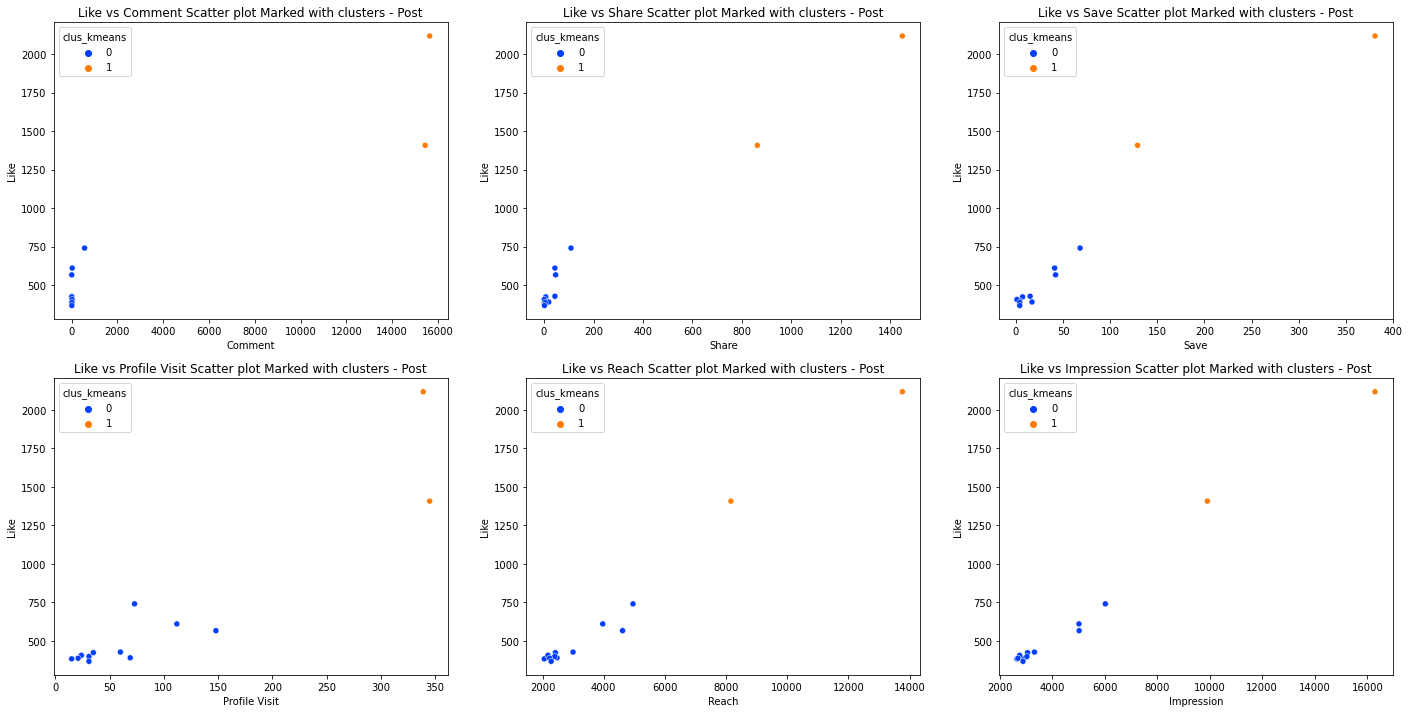

In [64]:
post_clus_x = np.asarray(df_post_kmeans.loc[:, ['like', 'comment', 'share', 'save', 'profile_visit', 'reach', 'impression']])
fig = plt.figure(figsize = (24, 12))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)

sns.scatterplot(x=post_clus_x[:, 1], y=post_clus_x[:, 0], hue=df_post_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax1)
ax1.set_ylabel('Like')
ax1.set_xlabel('Comment')
ax1.set_title('Like vs Comment Scatter plot Marked with clusters - Post')

sns.scatterplot(x=post_clus_x[:, 2], y=post_clus_x[:, 0], hue=df_post_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax2)
ax2.set_ylabel('Like')
ax2.set_xlabel('Share')
ax2.set_title('Like vs Share Scatter plot Marked with clusters - Post')

sns.scatterplot(x=post_clus_x[:, 3], y=post_clus_x[:, 0], hue=df_post_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax3)
ax3.set_ylabel('Like')
ax3.set_xlabel('Save')
ax3.set_title('Like vs Save Scatter plot Marked with clusters - Post')

sns.scatterplot(x=post_clus_x[:, 4], y=post_clus_x[:, 0], hue=df_post_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax4)
ax4.set_ylabel('Like')
ax4.set_xlabel('Profile Visit')
ax4.set_title('Like vs Profile Visit Scatter plot Marked with clusters - Post')

sns.scatterplot(x=post_clus_x[:, 5], y=post_clus_x[:, 0], hue=df_post_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax5)
ax5.set_ylabel('Like')
ax5.set_xlabel('Reach')
ax5.set_title('Like vs Reach Scatter plot Marked with clusters - Post')

sns.scatterplot(x=post_clus_x[:, 6], y=post_clus_x[:, 0], hue=df_post_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax6)
ax6.set_ylabel('Like')
ax6.set_xlabel('Impression')
ax6.set_title('Like vs Impression Scatter plot Marked with clusters - Post')

plt.show()

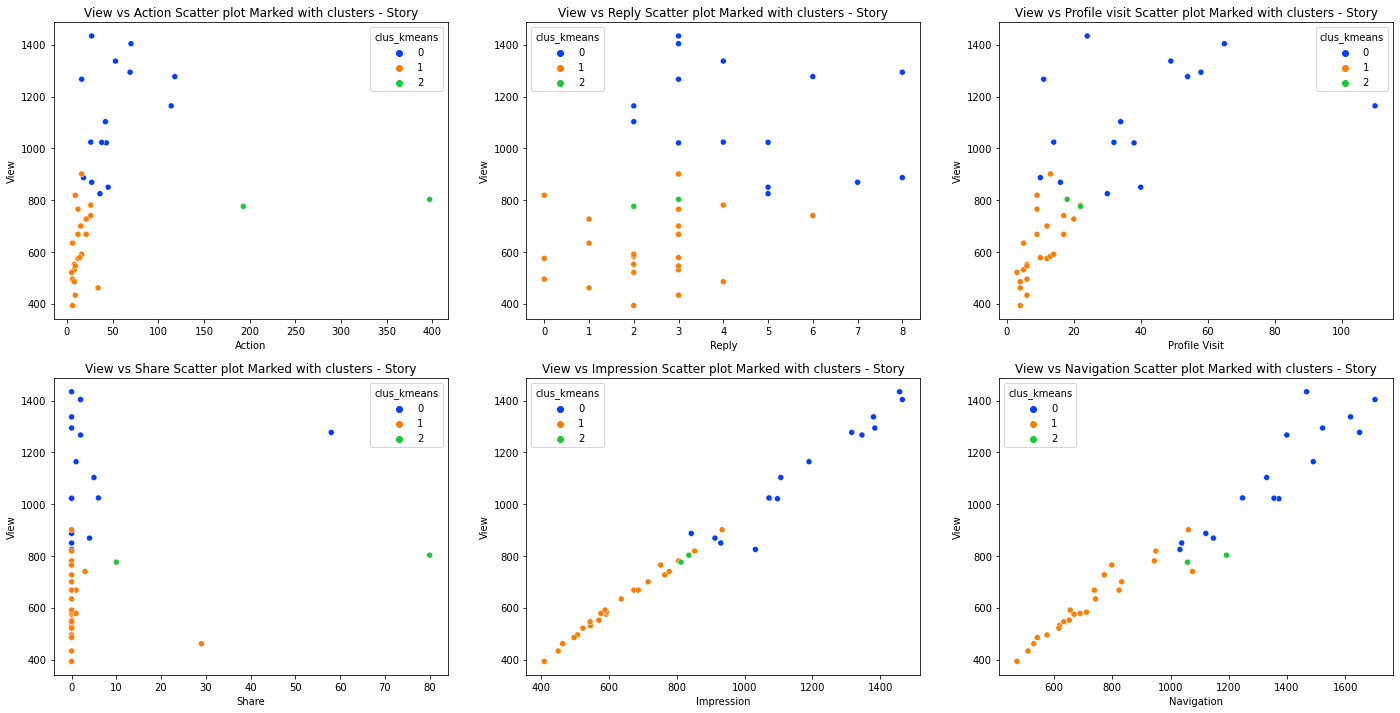

In [65]:
story_clus_x = np.asarray(df_story_kmeans.loc[:, ['view', 'action', 'reply', 'profile_visit', 'share', 'impression', 'navigation']])
fig = plt.figure(figsize = (24, 12))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)

sns.scatterplot(x=story_clus_x[:, 1], y=story_clus_x[:, 0], hue=df_story_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax1)
ax1.set_ylabel('View')
ax1.set_xlabel('Action')
ax1.set_title('View vs Action Scatter plot Marked with clusters - Story')

sns.scatterplot(x=story_clus_x[:, 2], y=story_clus_x[:, 0], hue=df_story_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax2)
ax2.set_ylabel('View')
ax2.set_xlabel('Reply')
ax2.set_title('View vs Reply Scatter plot Marked with clusters - Story')

sns.scatterplot(x=story_clus_x[:, 3], y=story_clus_x[:, 0], hue=df_story_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax3)
ax3.set_ylabel('View')
ax3.set_xlabel('Profile Visit')
ax3.set_title('View vs Profile visit Scatter plot Marked with clusters - Story')

sns.scatterplot(x=story_clus_x[:, 4], y=story_clus_x[:, 0], hue=df_story_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax4)
ax4.set_ylabel('View')
ax4.set_xlabel('Share')
ax4.set_title('View vs Share Scatter plot Marked with clusters - Story')

sns.scatterplot(x=story_clus_x[:, 5], y=story_clus_x[:, 0], hue=df_story_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax5)
ax5.set_ylabel('View')
ax5.set_xlabel('Impression')
ax5.set_title('View vs Impression Scatter plot Marked with clusters - Story')

sns.scatterplot(x=story_clus_x[:, 6], y=story_clus_x[:, 0], hue=df_story_kmeans['clus_kmeans'], palette='bright', alpha=1.0, edgecolor='white', ax=ax6)
ax6.set_ylabel('View')
ax6.set_xlabel('Navigation')
ax6.set_title('View vs Navigation Scatter plot Marked with clusters - Story')

plt.show()

### DBSCAN

In [66]:
from sklearn.neighbors import NearestNeighbors  
from sklearn.cluster import DBSCAN
from matplotlib.lines import Line2D

In [68]:
neigh_post = NearestNeighbors(n_neighbors=2)
neigh_story = NearestNeighbors(n_neighbors=2)
nbrs_post = neigh_post.fit(post_x)
nbrs_story = neigh_story.fit(story_x)
distances_post, _ = nbrs_post.kneighbors(post_x)
distances_story, _ = nbrs_story.kneighbors(story_x)
distances_post = np.sort(distances_post, axis=0)
distances_story = np.sort(distances_story, axis=0)
distances_post = distances_post[:,1]
distances_story = distances_story[:,1]

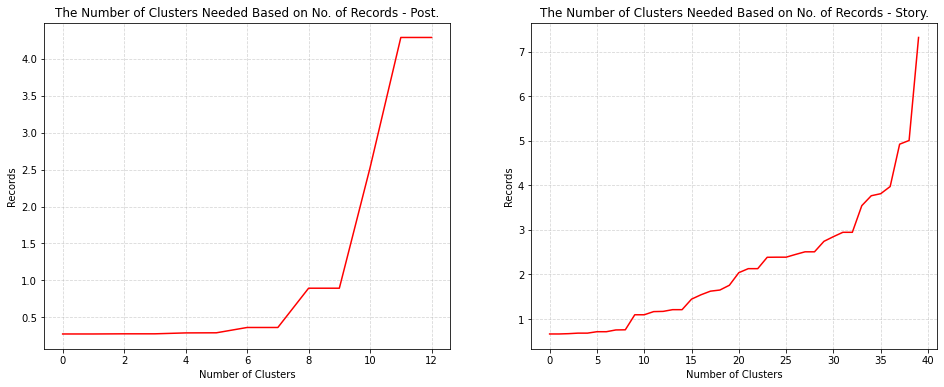

In [70]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(distances_post, 'r-')
ax1.set_ylabel('Records')
ax1.set_xlabel('Number of Clusters')
ax1.set_title('The Number of Clusters Needed Based on No. of Records - Post.')
ax1.grid(linestyle='--', alpha=0.5)
ax2.plot(distances_story, 'r-')
ax2.set_ylabel('Records')
ax2.set_xlabel('Number of Clusters')
ax2.set_title('The Number of Clusters Needed Based on No. of Records - Story.')
ax2.grid(linestyle='--', alpha=0.5)
plt.show()

Like the Elbow Method, we pick the point that our curvature starts to rise exponentially as the epsilon, for Posts dataset it is **0.8** and for Story dataset is **5**.

In [81]:
clus_dbscan_post = DBSCAN(eps=.8, min_samples=2)
clus_dbscan_story = DBSCAN(eps=5, min_samples=3)
clus_dbscan_post.fit(post_x)
clus_dbscan_story.fit(story_x)
clusters_post = clus_dbscan_post.labels_
clusters_story = clus_dbscan_story.labels_
colors = ['wheat', 'orange', 'lawngreen', 'cyan', 'royalblue', 'darkviolet', 'magenta', 'pink', 'darkgreen', 'red']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
c_post = vectorizer(clusters_post)
c_story = vectorizer(clusters_story)

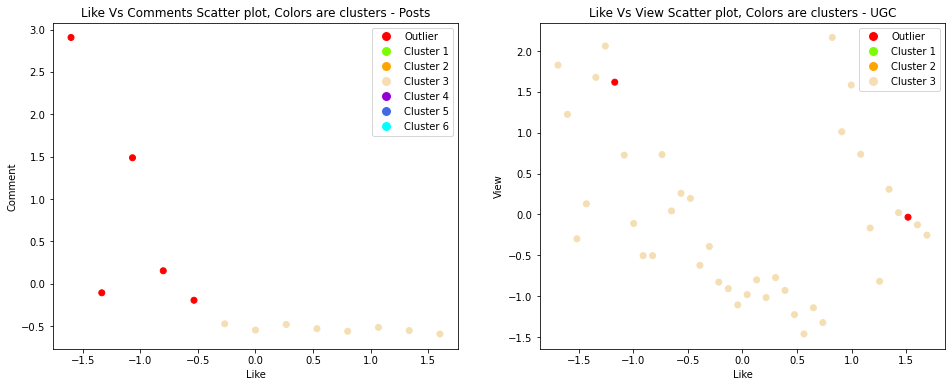

In [83]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(post_x[:,0], post_x[:,1], c=c_post)
line1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red", label='Outlier', markersize='10')
line2 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="lawngreen", label='Cluster 1', markersize='10')
line3 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="orange", label='Cluster 2', markersize='10')
line4 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="wheat", label='Cluster 3', markersize='10')
line5 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="darkviolet", label='Cluster 4', markersize='10')
line6 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="royalblue", label='Cluster 5', markersize='10')
line7 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="cyan", label='Cluster 6', markersize='10')
ax1.legend(handles=[line1, line2, line3, line4, line5, line6, line7])
ax1.set_xlabel('Like')
ax1.set_ylabel('Comment')
ax1.set_title('Like Vs Comments Scatter plot, Colors are clusters - Posts')
ax2.scatter(story_x[:,0], story_x[:,1], c=c_story)
line1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red", label='Outlier', markersize='10')
line2 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="lawngreen", label='Cluster 1', markersize='10')
line3 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="orange", label='Cluster 2', markersize='10')
line4 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="wheat", label='Cluster 3', markersize='10')
ax2.legend(handles=[line1, line2, line3, line4])
ax2.set_xlabel('Like')
ax2.set_ylabel('View')
ax2.set_title('Like Vs View Scatter plot, Colors are clusters - UGC')

plt.show()